# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")



import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re

import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [ ]:
# using the SQLite Table to read data.
from google.colab import drive
drive.mount('/content/drive')
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3

con=sqlite3.connect("/content/drive/MyDrive/appiedAI/AMAZON_FINE_FOOD_REVIEW/database.sqlite")

filtered_data=pd.read_sql_query("SELECT * FROM Reviews WHERE Score!=3 LIMIT 5000",con)

# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
  if x<3:
    return 0
  return 1


#changing reviews with score less than 3 to be positive and vice-versa
actualScore=filtered_data['Score']
positiveNegative=actualScore.map(partition)
filtered_data["Score"]=positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [ ]:
display=pd.read_sql_query(""" 
                           SELECT  UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
                           FROM Reviews GROUP BY ProductId
                           HAVING COUNT(*)>1""",con)



In [ ]:
print(display.shape)
display.head()

(43850, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,A25ACLV5KPB4W,0006641040,"Matt Hetling ""Matt""",1108425600,4,In June<br />I saw a charming group<br />of ro...,37
1,A1C298ITT645B6,2734888454,Hugh G. Pritchard,1195948800,5,Our dogs just love them. I saw them in a pet ...,2
2,ADODIH2V6UBQ9,7310172001,R. Miller,1315008000,5,By far this treat is the best one that I have ...,173
3,ADODIH2V6UBQ9,7310172101,R. Miller,1315008000,5,By far this treat is the best one that I have ...,173
4,A32EOHLFZYXJEP,7800648702,Jaylia3,1338940800,3,"There are almost 80 of these crispy, cream-fil...",2


In [ ]:
display[display["UserId"]=="AZY10LLTJ71NX"]

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
23277,AZY10LLTJ71NX,B001P7AXXG,"undertheshrine ""undertheshrine""",1303776000,5,This popcorn is probably the best microwave po...,2


In [ ]:
display['COUNT(*)'].sum()

538046

#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication


It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [ ]:
display=pd.read_sql_query(""" SELECT * FROM Reviews 
                              WHERE Score!=3 AND UserId="AR5J8UI46CURR"
                              ORDER BY ProductID """,con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [ ]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values("ProductId",axis=0,ascending=True,inplace=False,na_position="last",kind="quicksort")

In [ ]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"},keep="first",inplace=False)
final.shape

(4986, 10)

In [ ]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [ ]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [ ]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [ ]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

(4986, 10)


In [ ]:
final["Score"].value_counts()

1    4178
0     808
Name: Score, dtype: int64

# [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [ ]:
# printing some random reviews
sent_0=final["Text"].values[0]
print(sent_0)
print("="*50)

sent_1000=final["Text"].values[1000]
print(sent_1000)
print("="*50)

sent_1500=final["Text"].values[1500]
print(sent_1500)
print("="*50)

sent_4900=final["Text"].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [ ]:
#remove url
sent_0=re.sub(r"http\S+","",sent_0)
sent_1000=re.sub(r"http\S+","",sent_1000)
sent_1500=re.sub(r"http\S+","",sent_1500)
sent_4900=re.sub(r"http\S+","",sent_4900)

sent_0

'Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.'

In [ ]:
from bs4 import BeautifulSoup

soup=BeautifulSoup(sent_0,"lxml")
text=soup.get_text()
print(text)
print("="*50)

soup=BeautifulSoup(sent_1000,"lxml")
text=soup.get_text()
print(text)
print("="*50)

soup=BeautifulSoup(sent_1500,"lxml")
text=soup.get_text()
print(text)
print("="*50)


soup=BeautifulSoup(sent_4900,"lxml")
text=soup.get_text()
print(text)
print("="*50)



Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [ ]:
#remove contraction
import re
def decontracted(phrase):
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)

  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)
  return phrase


In [ ]:
sent_1500=decontracted(sent_1500)
print(sent_1500)


Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [ ]:
#remove words with numbers python
sent_0=re.sub("\S*\d\S*","",sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [ ]:
#remove spacial character
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [ ]:
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_review=[]
for sentence in tqdm(final["Text"].values):
  sentence=re.sub(r"http\S+","",sentence)
  sentence=BeautifulSoup(sentence,"lxml").get_text()
  sentence=decontracted(sentence)
  sentence=re.sub("\S*\d\S*","",sentence).strip()
  sentence=re.sub('[^A-Za-z]+',' ',sentence)
  sentence=' '.join(e.lower() for e in sentence.split() if e.lower not in stopwords)
  preprocessed_review.append(sentence.strip())

100%|██████████| 4986/4986 [00:01<00:00, 2784.45it/s]


In [ ]:
preprocessed_review[200]

'i purchased this item to celebrate the birth of my grandson i should have opted for real cigars they might have tasted better these cigars were very hard and hurt my teeth to chew not to mention that these gum cigars were much too sweet'

In [ ]:
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_review)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_review)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])


some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 13125)
the number of unique words  13125


##  BAG OF WORDS

In [ ]:
#BoW
count_vect=CountVectorizer()
count_vect.fit(preprocessed_review)
print("some feature name",count_vect.get_feature_names()[:10])
print('='*50)

final_counts=count_vect.transform(preprocessed_review)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words",final_counts.get_shape()[1])

some feature name ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 13125)
the number of unique words 13125


##  Bi-Grams and n-Grams.


In [ ]:
count_vect=CountVectorizer(ngram_range=(1,2),min_df=10,max_features=100)
final_bigram_counts=count_vect.fit_transform(preprocessed_review)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 100)
the number of unique words including both unigrams and bigrams  100


##  TF-IDF

In [ ]:
tf_idf_vec = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vec.fit(preprocessed_review)
print("some sample features(unique words in the corpus)",tf_idf_vec.get_feature_names()[0:10])
print("="*50)

final_tf_idf=tf_idf_vec.transform(preprocessed_review)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able to', 'about', 'about half', 'about how', 'about it', 'about minutes', 'about months', 'about my']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 6632)
the number of unique words including both unigrams and bigrams  6632


##  Converting text into vectors using wAvg W2V, TFIDF-W2V

####  Avg W2v

In [ ]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))




100%|██████████| 4986/4986 [00:05<00:00, 872.06it/s]

4986
50


####  TFIDF weighted W2v

In [ ]:
model = TfidfVectorizer()
model.fit(preprocessed_review)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [ ]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:56<00:00, 87.73it/s] 


#K-Means **Clustering**

## Applying K-Means Clustering on BOW

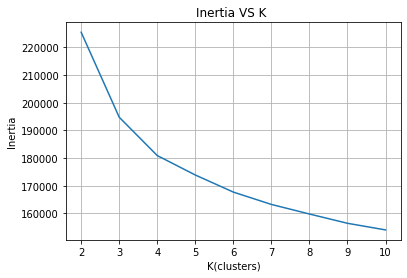

In [ ]:

# Please write all the code with proper documentation
from sklearn.cluster import KMeans
count_vect = CountVectorizer(min_df = 1000)
X_train=count_vect.fit_transform(preprocessed_review)
k=[2,3,4,5,6,7,8,9,10]
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(X_train)
    inertia.append(model.inertia_)
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [ ]:
#we can see that at k=3 there is a point of inflection
k=3
model=KMeans(n_clusters=3, n_jobs=-1)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
cluster1,cluster2,cluster3=[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(preprocessed_review[i])
    elif model.labels_[i] == 1:
        cluster2.append(preprocessed_review[i])
    else:
        cluster3.append(preprocessed_review[i])

### Wordclouds of clusters obtained after applying k-means on BOW

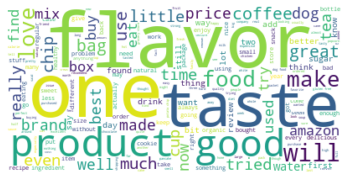

In [ ]:
#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

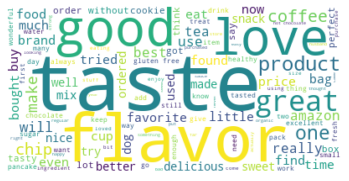

In [ ]:

#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

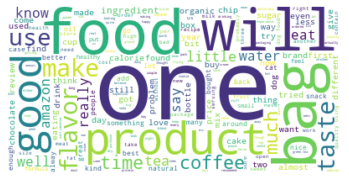

In [ ]:
#for cluster 3
data=''
for i in cluster3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Top terms per clusters

In [ ]:
#https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster
print("Top 3 terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = count_vect.get_feature_names()
for i in range(k):
    print("Cluster %d:" % (i+1), end='')
    for ind in order_centroids[i, :3]:
        print(' %s' % terms[ind], end='')
        print()
    print('-'*50)

Top 3 terms per cluster:
Cluster 1: the
 and
 to
--------------------------------------------------
Cluster 2: the
 and
 is
--------------------------------------------------
Cluster 3: the
 and
 to
--------------------------------------------------


## Applying K-Means Clustering on TFIDF

In [ ]:
# Please write all the code with proper documentation
from sklearn.cluster import KMeans
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=1000)
X_train=tf_idf_vect.fit_transform(preprocessed_review)
X_train.shape

(4986, 37)

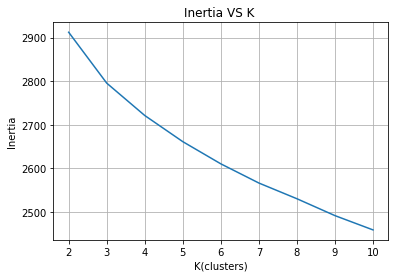

In [ ]:
k=[2,3,4,5,6,7,8,9,10]
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(X_train)
    inertia.append(model.inertia_)
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [ ]:
#we can see that at k=3 there is a point of inflection
model=KMeans(n_clusters=3, n_jobs=-1)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
cluster1,cluster2,cluster3=[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(preprocessed_review[i])
    elif model.labels_[i] == 1:
        cluster2.append(preprocessed_review[i])
    else:
        cluster3.append(preprocessed_review[i])

### Wordclouds of clusters obtained after applying k-means on TFIDF

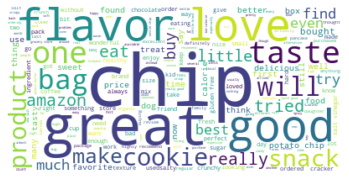

In [ ]:
#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

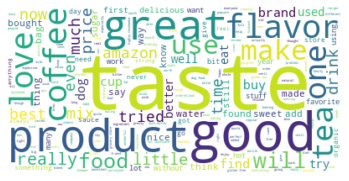

In [ ]:

#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

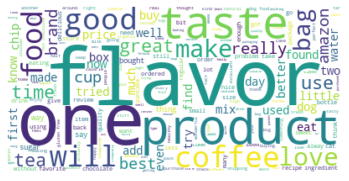

In [ ]:
#for cluster 3
data=''
for i in cluster3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Top features from each clusters¶


In [ ]:
#https://stackoverflow.com/questions/47452119/kmean-clustering-top-terms-in-cluster
print("Top 5 terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tf_idf_vect.get_feature_names()
for i in range(3):
    print("Cluster %d:" % (i+1), end='')
    for ind in order_centroids[i, :5]:
        print(' %s' % terms[ind], end='')
        print()
    print('-'*50)

Top 5 terms per cluster:
Cluster 1: are
 these
 they
 and
 the
--------------------------------------------------
Cluster 2: it
 is
 this
 and
 the
--------------------------------------------------
Cluster 3: the
 and
 of
 to
 is
--------------------------------------------------


## Applying K-Means Clustering on AVG W2V,

In [ ]:
list_of_sentance_train=[]
for sentance in preprocessed_review:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 4986/4986 [00:05<00:00, 885.56it/s]

4986
50


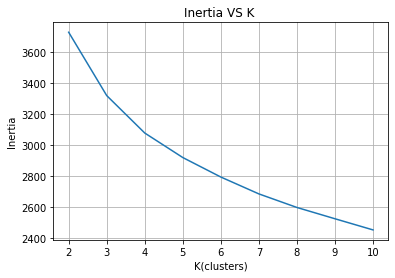

In [ ]:
k=[2,3,4,5,6,7,8,9,10]
X_train=sent_vectors_train
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(X_train)
    inertia.append(model.inertia_)
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [ ]:
#we can see that at k=3 there is a point of inflection
model=KMeans(n_clusters=3, n_jobs=-1)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:

cluster1,cluster2,cluster3=[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(preprocessed_review[i])
    elif model.labels_[i] == 1:
        cluster2.append(preprocessed_review[i])
    else:
        cluster4.append(preprocessed_review[i])

### Wordclouds of clusters obtained after applying k-means on AVG W2V

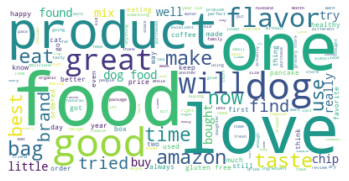

In [ ]:
#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

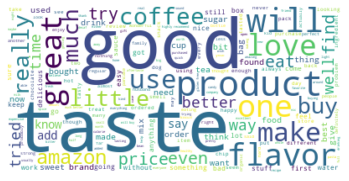

In [ ]:
#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

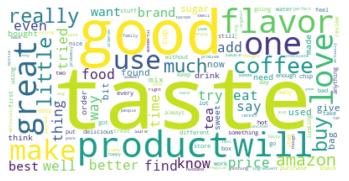

In [ ]:
#for cluster 3

data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Applying K-Means Clustering on TFIDF W2V

In [ ]:
list_of_sentance_train=[]
for sentance in preprocessed_review:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(preprocessed_review)


tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:11<00:00, 440.15it/s]


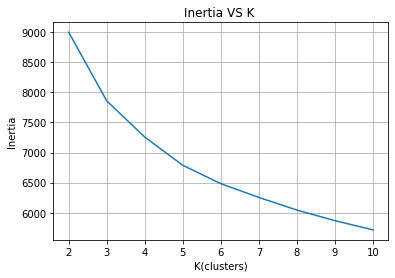

In [ ]:
k=[2,3,4,5,6,7,8,9,10]
X_train=tfidf_sent_vectors_train
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(X_train)
    inertia.append(model.inertia_)
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [ ]:
#we can see that at k=3 there is a point of inflection
model=KMeans(n_clusters=3, n_jobs=-1)
model.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
cluster1,cluster2,cluster3,cluster4=[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(preprocessed_review[i])
    elif model.labels_[i] == 1:
        cluster2.append(preprocessed_review[i])
    else:
        cluster3.append(preprocessed_review[i])

### Wordclouds of clusters obtained after applying k-means on TFIDF W2V

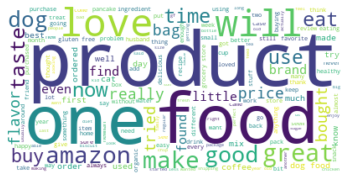

In [ ]:

#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

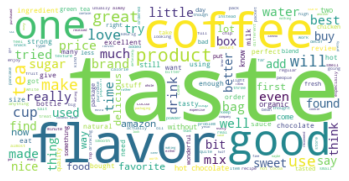

In [ ]:
#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

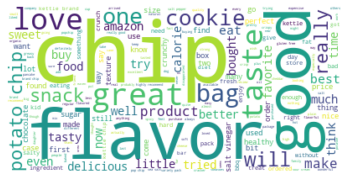

In [ ]:
#for cluster 3
data=''
for i in cluster3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Agglomerative Clustering

## Applying Agglomerative Clustering on AVG W2V

In [ ]:
preprocessed_review=preprocessed_review[:5000]
list_of_sentance_train=[]
for sentance in preprocessed_review:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 4986/4986 [00:05<00:00, 841.25it/s]

4986
50


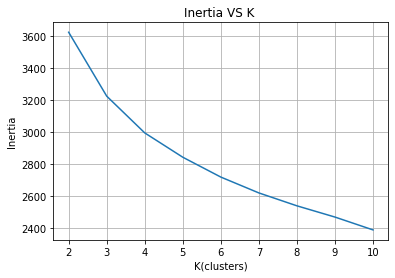

In [ ]:
k=[2,3,4,5,6,7,8,9,10]
X_train=sent_vectors_train
inertia=[]
for i in k:
    model=KMeans(n_clusters=i, n_jobs=-1)
    model.fit(X_train)
    inertia.append(model.inertia_)
#finding best k using elbow method    
plt.plot(k, inertia)
plt.xlabel('K(clusters)')
plt.ylabel('Inertia')
plt.title('Inertia VS K ')
plt.grid()
plt.show()

In [ ]:
#k=2
from sklearn.cluster import AgglomerativeClustering
X_train=sent_vectors_train
model=AgglomerativeClustering(n_clusters=2).fit(X_train)

In [ ]:

cluster1,cluster2=[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(preprocessed_review[i])
    else:
        cluster2.append(preprocessed_review[i])

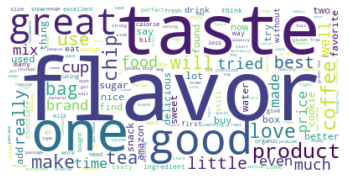

In [ ]:
#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

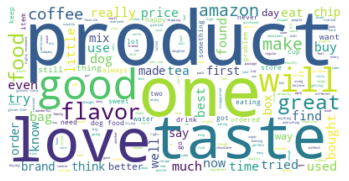

In [ ]:
#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
#k=5
X_train=sent_vectors_train
model=AgglomerativeClustering(n_clusters=5).fit(X_train)

In [ ]:
cluster1,cluster2,cluster3,cluster4,cluster5=[],[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(preprocessed_review[i])
    elif model.labels_[i] == 1:
        cluster2.append(preprocessed_review[i])
    elif model.labels_[i] == 2:
        cluster3.append(preprocessed_review[i])
    elif model.labels_[i] == 3:
        cluster4.append(preprocessed_review[i])
    else :
        cluster5.append(preprocessed_review[i])

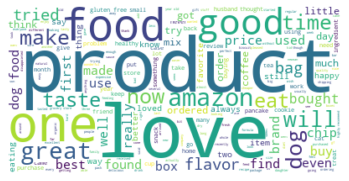

In [ ]:
#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

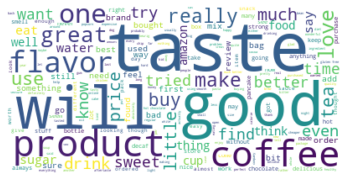

In [ ]:
#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

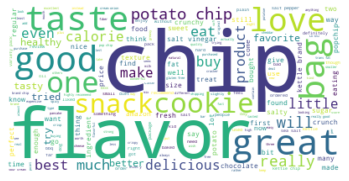

In [ ]:
#for cluster 3
data=''
for i in cluster3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

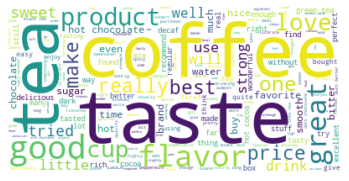

In [ ]:

#for cluster 5
data=''
for i in cluster5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Applying Agglomerative Clustering on TFIDF W2V

In [ ]:
list_of_sentance_train=[]
for sentance in preprocessed_review:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(preprocessed_review)


tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:11<00:00, 435.12it/s]


In [ ]:
#for k=2
from sklearn.cluster import AgglomerativeClustering
X_train=tfidf_sent_vectors_train
model=AgglomerativeClustering(n_clusters=2).fit(X_train)

In [ ]:
cluster1,cluster2=[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(preprocessed_review[i])
    else:
        cluster2.append(preprocessed_review[i])

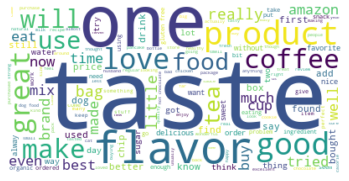

In [ ]:
#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

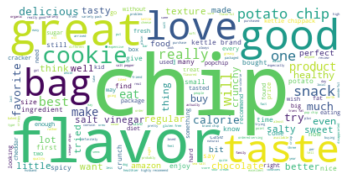

In [ ]:
#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
# for k=5
model=AgglomerativeClustering(n_clusters=5).fit(X_train)
cluster1,cluster2,cluster3,cluster4,cluster5=[],[],[],[],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(preprocessed_review[i])
    elif model.labels_[i] == 1:
        cluster2.append(preprocessed_review[i])
    elif model.labels_[i] == 2:
        cluster3.append(preprocessed_review[i])
    elif model.labels_[i] == 3:
        cluster4.append(preprocessed_review[i])
    else :
        cluster5.append(preprocessed_review[i])

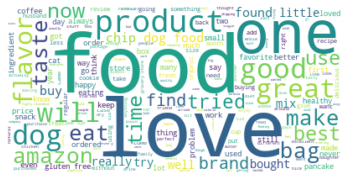

In [ ]:
#for cluster 1
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

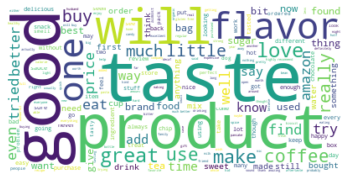

In [ ]:
#for cluster 2
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

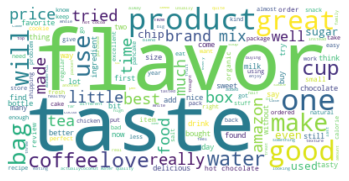

In [ ]:
#for cluster 3
data=''
for i in cluster3:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

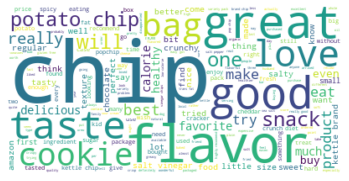

In [ ]:

#for cluster 4
data=''
for i in cluster4:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

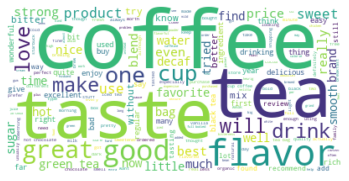

In [ ]:

#for cluster 5
data=''
for i in cluster5:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Conclusions

In [ ]:
#prettytable for kmeans
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Vectorizer","Best k"]
x.add_row(['BOW','3'])
x.add_row(['TFIDF','3'])
x.add_row(['AVG W2vec','3'])
x.add_row(['TFIDF W2vec','3'])
print(x)

+-------------+--------+
|  Vectorizer | Best k |
+-------------+--------+
|     BOW     |   3    |
|    TFIDF    |   3    |
|  AVG W2vec  |   3    |
| TFIDF W2vec |   3    |
+-------------+--------+
